# Example for the reference resistance calculation

In [42]:
%load_ext autoreload
%autoreload 2
%pylab inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from harps import salinity_harps as sh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/markusritschel/bin/miniconda3/envs/eurec4a/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axis']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### read in data from file and select module and variable

In [44]:
data = sh.read_harp_file('salinity_harps_test_data.dat')
data = data.sel(module=0)
resistance = data['r16']

read salinity harp now... done


/home/markusritschel/bin/miniconda3/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/markusritschel/bin/miniconda3/envs/eurec4a/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/markusritschel/bin/miniconda3/envs/eurec4a/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/markusritschel/bin/miniconda3/envs/eurec4a/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was 

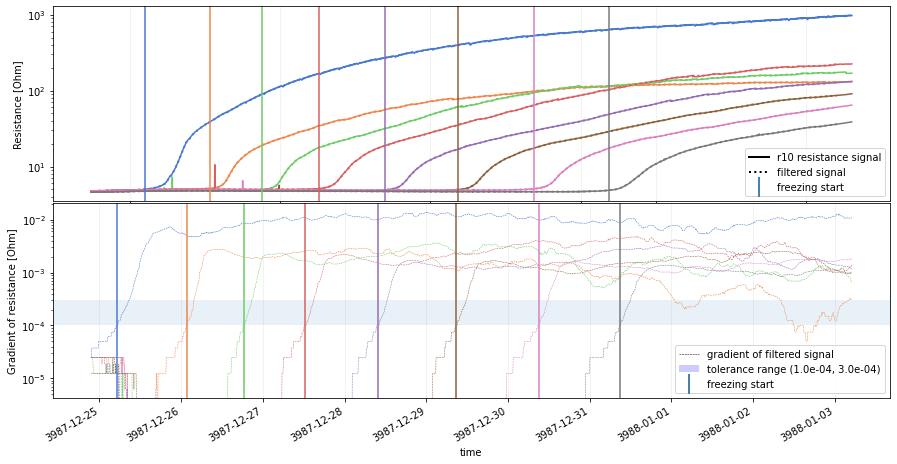

In [85]:
import seaborn as sns
colors = sns.color_palette("muted", 8)
#sns.palplot(colors, size=.5)

# smoothen the signal
resistance_smooth = sh.median(resistance)
# compute gradient of that smoothened signal
resistance_grad = sh.median(sh.grad(resistance_smooth, 20))

# find values that are in a certain range around 0.5 and mask others
tolerance = (1e-4, 3e-4)
grad_tol = np.where(np.logical_and(resistance_grad > tolerance[0], resistance_grad < tolerance[1]), resistance_grad, np.nan)
# set all those values to common value
grad_tol[~np.isnan(grad_tol)] = 1

# now find the first occurrence in that array which is not NAN
#ym = np.abs(y-0.5).argmin()
freezing_starts = np.nanargmin(grad_tol, axis=0).squeeze()

plt.figure(figsize=(15,8))
ax = plt.gca()
ax0 = plt.subplot(211)
ax1 = plt.subplot(212)

# plot resistance
resistance.squeeze().to_pandas().plot(logy=True, color=colors, ax=ax0)
resistance_smooth.squeeze().to_pandas().plot(color=colors, ax=ax0, ls=':', lw=2)

# plot gradient
# resistance_grad.squeeze().plot(x='time', hue='wire_pair', yscale='log', add_legend=False, ax=ax1)
resistance_grad.squeeze().to_pandas().plot(logy=True, color=colors, ax=ax1, ls='--', lw=.5)

#da_grad_cut.squeeze().to_pandas().plot(color=colors, ax=ax1, ls='--', lw=2, marker='', fillstyle='none', markevery=150)

ax1.axhspan(*tolerance, alpha=.1)

for i, c in enumerate(freezing_starts):
    ax0.axvline(x=resistance.time.values[c], color=colors[i])
    ax1.axvline(x=resistance.time.values[c], color=colors[i])


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

ax0_legend_elements = [Line2D([0], [0], color='k', lw=2, label='r10 resistance signal'),
                       Line2D([0], [0], color='k', ls=':', lw=2, label='filtered signal'),
                       Line2D([0], [0], color='steelblue', ls='', lw=1, marker='|', markersize=20, mew=2, label='freezing start'),
                       ]

ax1_legend_elements = [Line2D([0], [0], color='k', ls='--', lw=.5, label='gradient of filtered signal'),
                       #Line2D([0], [0], color='k', ls='--', lw=2, marker='', fillstyle='none', label='gradient of filtered signal < 1e-3'),
                       Patch(facecolor='b', alpha=.2, label='tolerance range ({:.1e}, {:.1e})'.format(*tolerance)),
                       Line2D([0], [0], color='steelblue', ls='', lw=1, marker='|', markersize=20, mew=2, label='freezing start'),
                       ]

ax0.tick_params(labelbottom=False)
ax0.set_xlabel(None)
ax0.set_ylabel('Resistance [Ohm]')
ax1.set_ylabel('Gradient of resistance [Ohm]')
plt.subplots_adjust(hspace=0.01)
for axis in plt.gcf().axes:
    axis.grid(axis='x', alpha=.2)
    # axis.set_xlim(resistance.squeeze().to_pandas().index[0], resistance.squeeze().to_pandas().index[-1])


ax0.legend(handles=ax0_legend_elements, loc='lower right')
ax1.legend(handles=ax1_legend_elements, loc='lower right')


In [91]:
r0s = sh.calc_reference_resistance(data, 'r16')#, kind='butterworth', tolerance=(1e-4, 3e-4))
T_freeze = data['temperature'].sel(time=r0s.coords['time'])


/home/markusritschel/bin/miniconda3/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<xarray.DataArray 'temperature' (wire_pair: 8)>
array([-1.562, -1.438, -1.375, -1.312, -1.375, -1.562, -1.375, -1.438])
Coordinates:
    time       (wire_pair) datetime64[ns] 2018-12-24T07:24:01 ... 2018-12-30T10:40:17
    module     int64 0
  * wire_pair  (wire_pair) int64 0 1 2 3 4 5 6 7

In [92]:
ds = sh.read_harp_data(file='salinity_harps_test_data.dat', module=0)
ds

read salinity harp now... done


/home/markusritschel/bin/miniconda3/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<xarray.Dataset>
Dimensions:             (time: 4999, wire_pair: 8)
Coordinates:
  * time                (time) datetime64[ns] 2018-12-23T11:41:11 ... 2019-01-02T14:37:04
    module              int64 0
  * wire_pair           (wire_pair) int64 0 1 2 3 4 5 6 7
Data variables:
    d16                 (time, wire_pair) float64 2.0 2.0 2.0 ... 2.0 nan nan
    d2                  (time, wire_pair) float64 2.0 2.0 2.0 ... 2.0 nan nan
    logger_temp         (time, wire_pair) float64 -16.33 -16.33 ... nan nan
    r16                 (time, wire_pair) float64 4.741 4.783 4.656 ... nan nan
    r2                  (time, wire_pair) float64 7.886 7.885 7.824 ... nan nan
    temperature         (time, wire_pair) float64 0.5 1.375 1.312 ... nan nan
    brine salinity      (time, wire_pair) float64 nan nan nan ... 48.6 nan nan
    solid fraction      (time, wire_pair) float64 nan nan nan ... 0.9443 nan nan
    liquid fraction     (time, wire_pair) float64 nan nan nan ... nan nan
    bulk salinity       (time, wire_pair) float64 nan nan nan ... 2.708 nan nan
    temperature_freeze  (wire_pair) float64 -1.562 -1.438 ... -1.375 -1.438
Attributes:
    Temperature:  °C
    Resistance:   Ohm

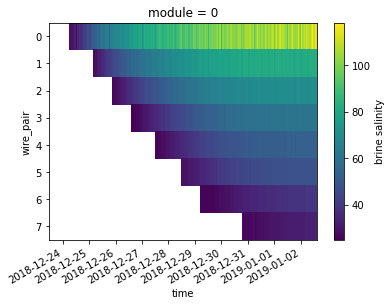

In [93]:
ds['brine salinity'].plot(x='time', yincrease=False)